In [3]:
import os
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

np.random.seed(42)

In [4]:
# 表示形式
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=5, floatmode='maxprec')
np.set_printoptions(suppress=True)

In [5]:
my_df = pd.read_csv('mb_submission_level5_1031_2.csv')
good_df = pd.read_csv('0.1336_lstm5fold_submission.csv')

test_df = pd.read_csv('../input/ventilator-pressure-prediction/test.csv')

In [6]:
test_df['breath_id']=[i for i in range(4024000//80) for e in range(80)]

In [7]:
display(my_df.head())
display(good_df.head())

display(test_df.head())

,id,pressure
0,1,6.32961
1,2,5.97810
2,3,7.10293
3,4,7.59505
4,5,9.14169


,id,pressure
0,1,6.25934
1,2,5.97813
2,3,7.10297
3,4,7.59509
4,5,9.14175


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.00000,0.00000,0
1,2,0,5,20,0.03190,7.51505,0
2,3,0,5,20,0.06383,14.65168,0
3,4,0,5,20,0.09575,21.23061,0
4,5,0,5,20,0.12764,26.32096,0


In [8]:
pred_df = pd.merge(my_df, good_df, on='id', suffixes=['_my', '_good'])
pred_df['error'] = np.abs(pred_df['pressure_my']-pred_df['pressure_good'])
pred_df['breath_id'] = [i for i in range(4024000//80) for e in range(80)]

masked_df = pred_df
masked_df['error'] = masked_df.mask(test_df['u_out']==1)['error']

In [9]:
test_df.head()

,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.00000,0.00000,0
1,2,0,5,20,0.03190,7.51505,0
2,3,0,5,20,0.06383,14.65168,0
3,4,0,5,20,0.09575,21.23061,0
4,5,0,5,20,0.12764,26.32096,0


In [10]:
pred_df.head()

,id,pressure_my,pressure_good,error,breath_id
0,1,6.32961,6.25934,0.07026,0
1,2,5.97810,5.97813,0.00004,0
2,3,7.10293,7.10297,0.00004,0
3,4,7.59505,7.59509,0.00005,0
4,5,9.14169,9.14175,0.00005,0


In [11]:
masked_df

,id,pressure_my,pressure_good,error,breath_id
0,1,6.32961,6.25934,0.07026,0
1,2,5.97810,5.97813,0.00004,0
2,3,7.10293,7.10297,0.00004,0
3,4,7.59505,7.59509,0.00005,0
4,5,9.14169,9.14175,0.00005,0
...,...,...,...,...,...
4023995,4023996,6.18900,6.18904,NaN,50299
4023996,4023997,6.32961,6.32965,NaN,50299
4023997,4023998,6.39991,6.32965,NaN,50299
4023998,4023999,6.18900,6.11874,NaN,50299


In [12]:
np.array(pred_df['error']).reshape(-1, 80)

array([[0.07026, 0.00004, 0.00004, ...,     nan,     nan,     nan],
       [0.00004, 0.07026, 0.00004, ...,     nan,     nan,     nan],
       [0.07026, 0.07025, 0.00008, ...,     nan,     nan,     nan],
       ...,
       [0.00004, 0.00004, 0.07038, ...,     nan,     nan,     nan],
       [0.00004, 0.07036, 0.00007, ...,     nan,     nan,     nan],
       [0.07027, 0.07027, 0.00006, ...,     nan,     nan,     nan]])

In [13]:
MAE_id = masked_df.groupby('breath_id').agg(np.nanmean)['error']

In [14]:
MAE_id.head

<bound method NDFrame.head of breath_id
0       0.02046
1       0.00974
2       0.02433
3       0.04689
4       0.01703
          ...  
50295   0.04682
50296   0.11110
50297   0.02866
50298   0.00978
50299   0.01878
Name: error, Length: 50300, dtype: float64>

# Basic Exploration

In [15]:
MAE_id.describe()

count   50300.00000
mean        0.04308
std         0.05916
min         0.00004
25%         0.02185
50%         0.03284
75%         0.04851
max         3.72617
Name: error, dtype: float64

In [16]:
MAE_id.quantile(0.95)

0.10419620227560442

<AxesSubplot:>

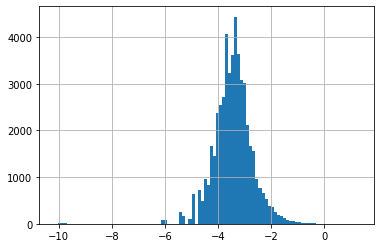

In [17]:
np.log(MAE_id).hist(bins=100)

<AxesSubplot:>

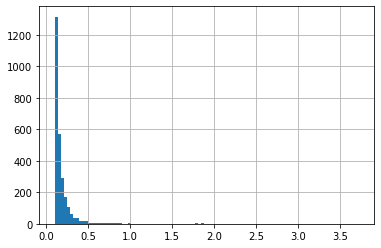

In [18]:
MAE_id.where(MAE_id > 0.1).hist(bins=100)

In [19]:
MAE_id_sorted = MAE_id.sort_values(ascending=False)

In [20]:
MAE_id_sorted

breath_id
44148   3.72617
22284   3.53279
32151   3.04580
10889   2.16189
23432   2.08401
          ...  
16390   0.00005
39165   0.00005
28322   0.00005
5548    0.00005
13268   0.00004
Name: error, Length: 50300, dtype: float64

In [26]:
MAE_id_sorted[1000:1010]

breath_id
46956   0.15934
38377   0.15933
4771    0.15932
28890   0.15890
45670   0.15886
29767   0.15886
41588   0.15886
38738   0.15885
21863   0.15878
16498   0.15874
Name: error, dtype: float64

# worst predictions

cluster:37621 MAE: 0.134


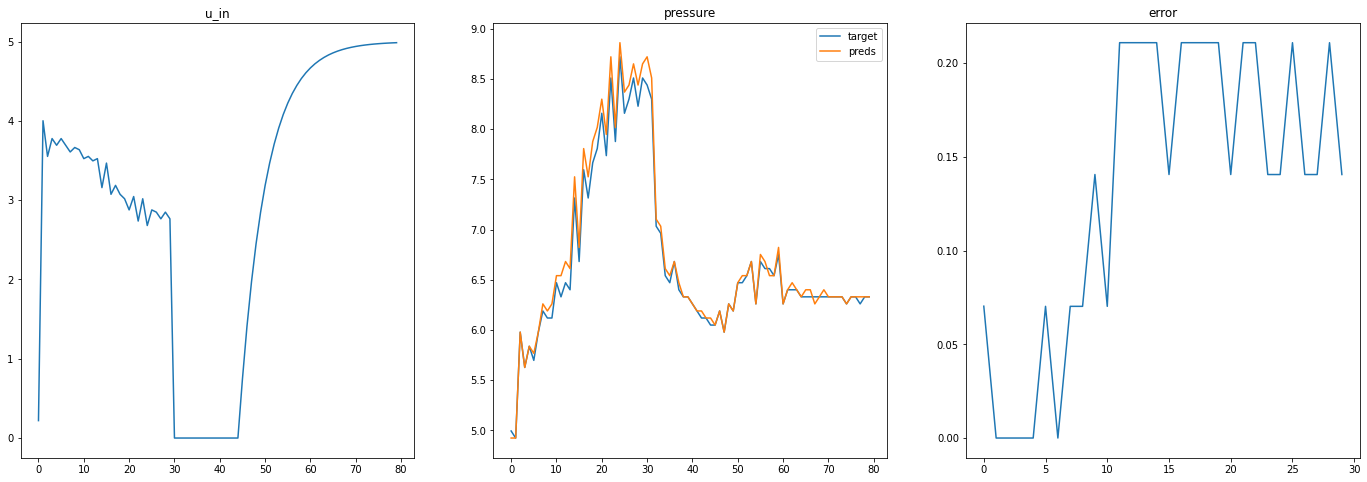

cluster:16034 MAE: 0.134


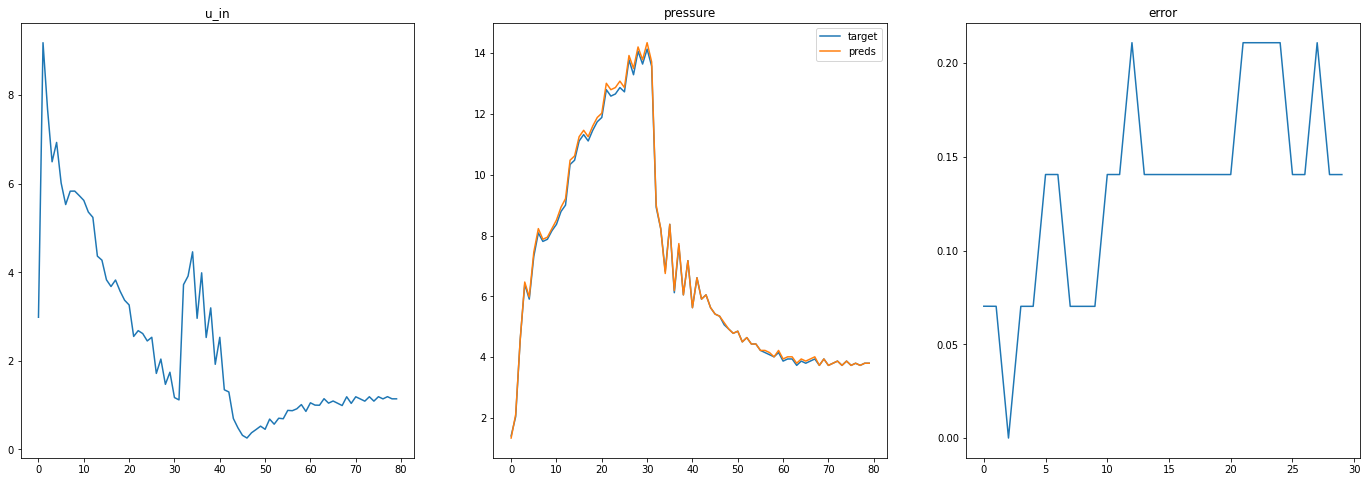

cluster:42109 MAE: 0.134


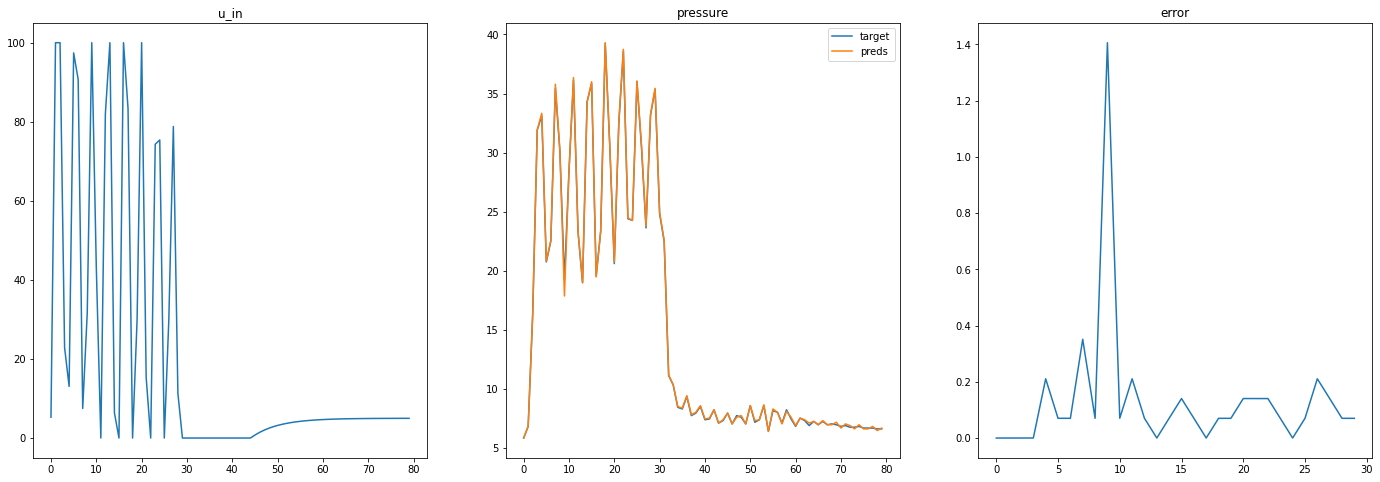

cluster:13132 MAE: 0.133


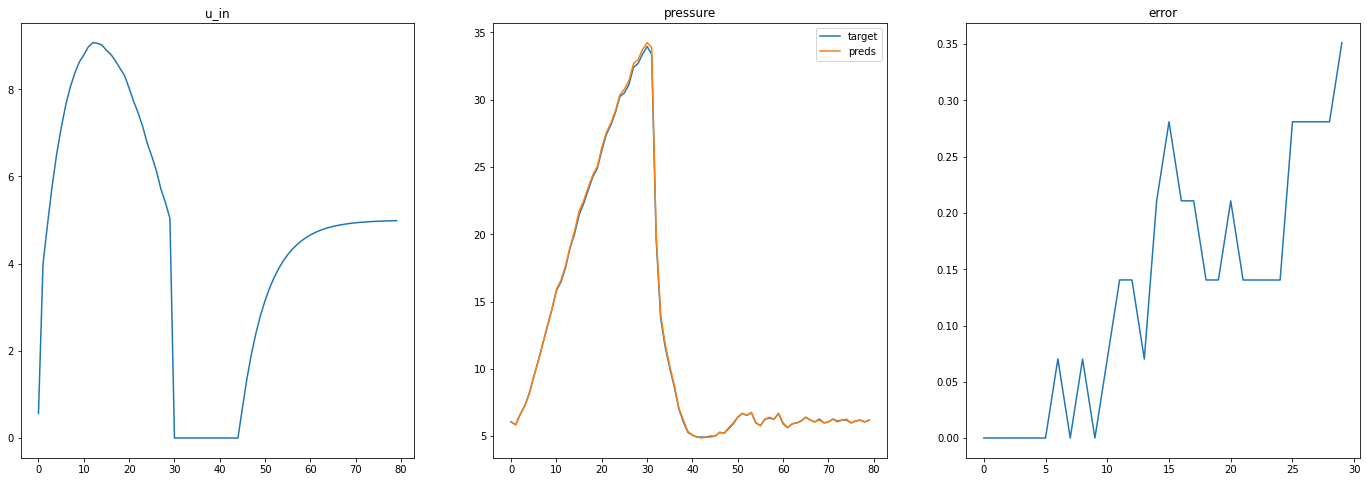

cluster:2700 MAE: 0.133


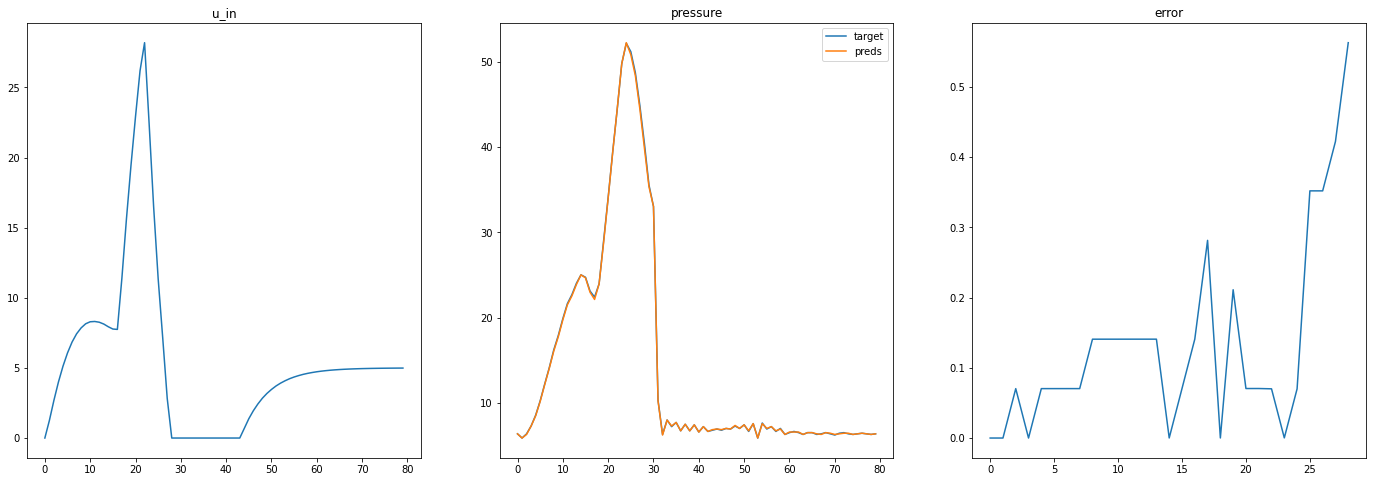

cluster:7398 MAE: 0.133


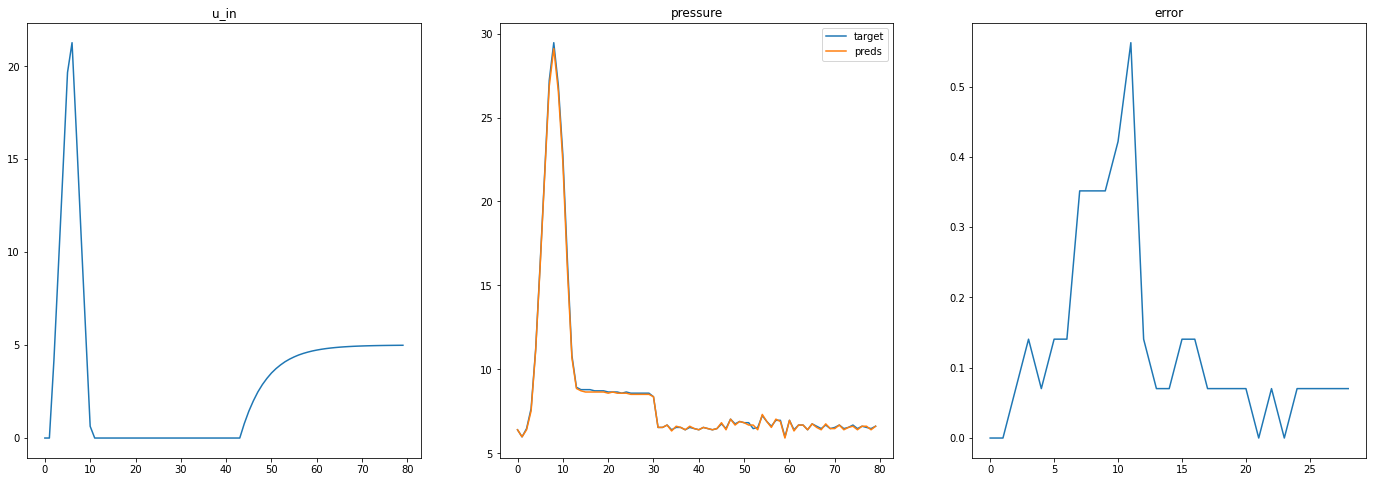

cluster:24354 MAE: 0.133


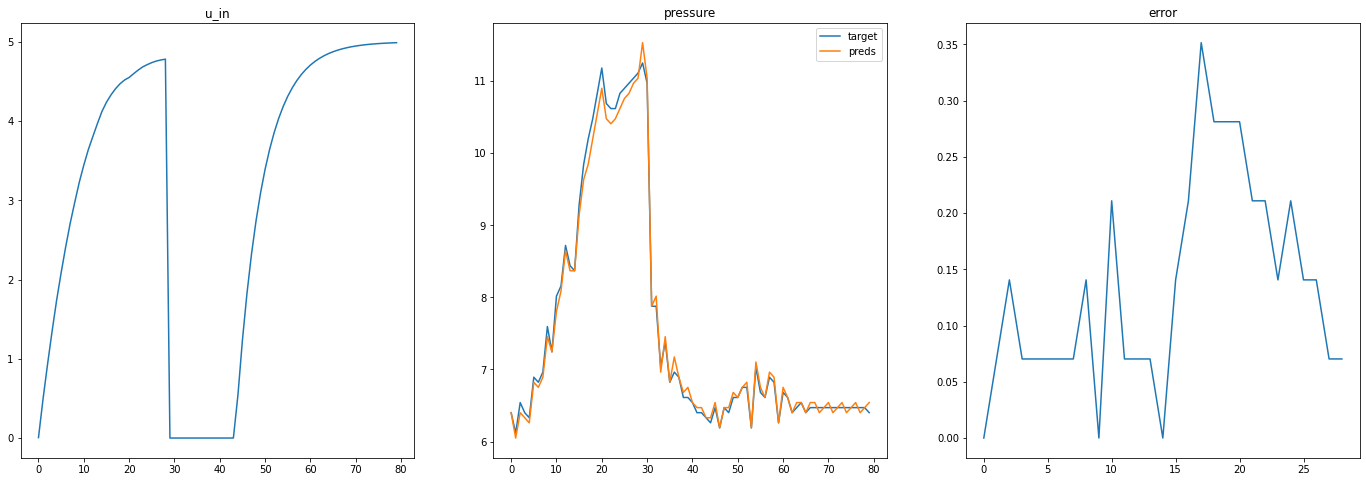

cluster:43339 MAE: 0.133


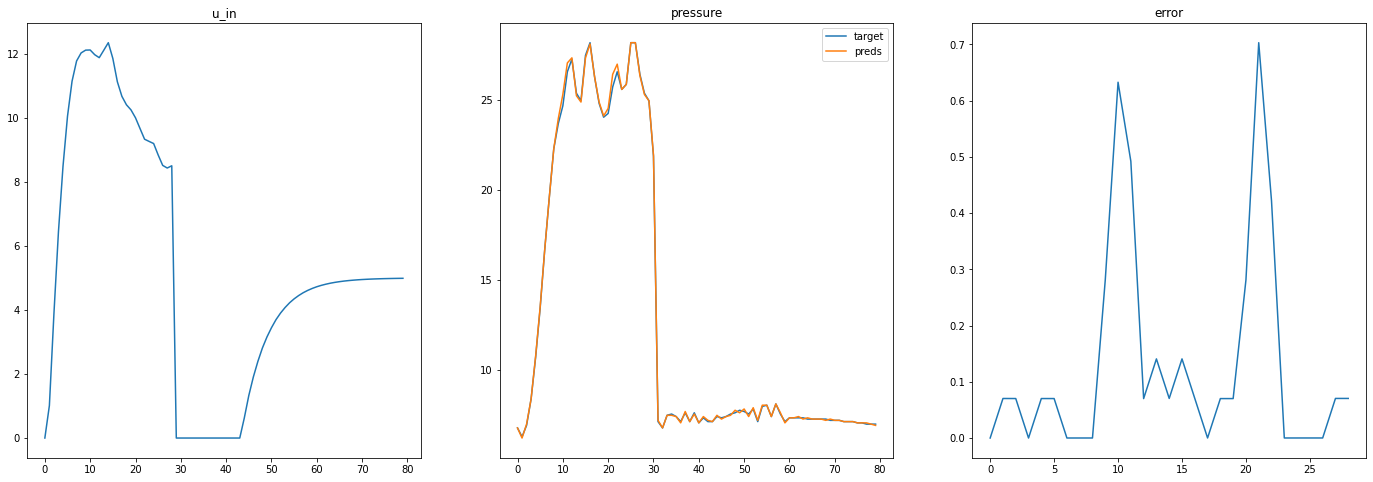

cluster:13445 MAE: 0.133


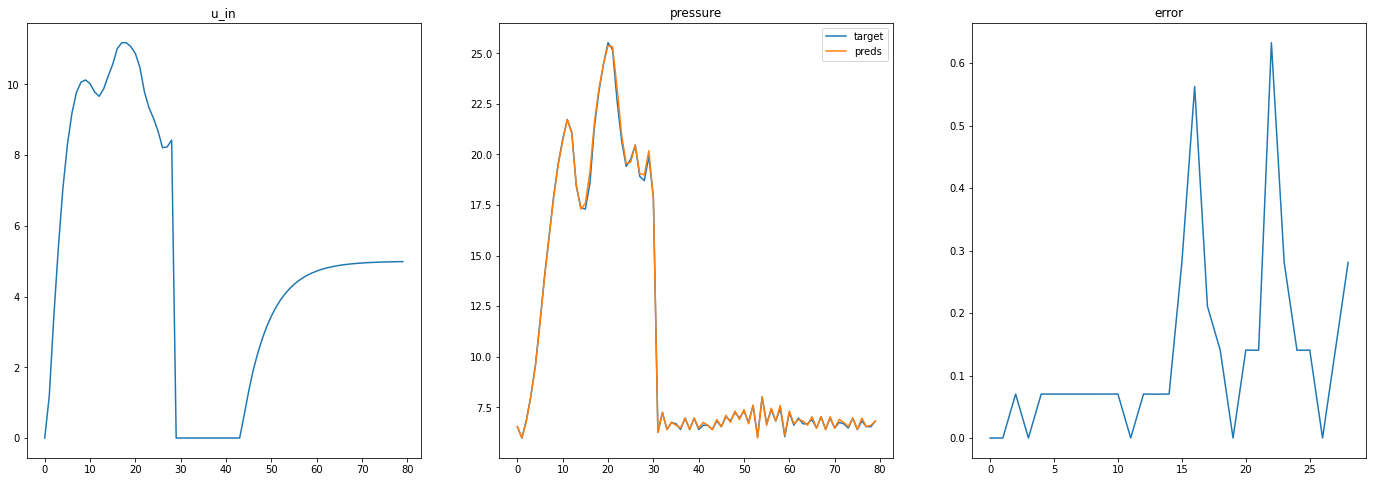

cluster:3677 MAE: 0.133


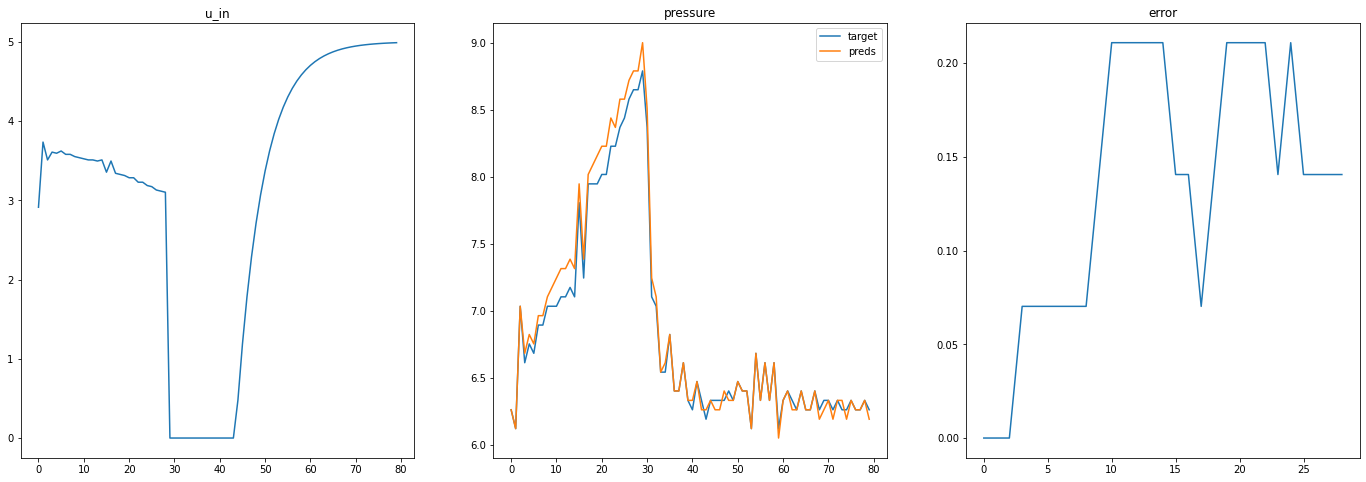

In [28]:
for i in MAE_id_sorted.index[1500:1510]:
    ind = np.int(i)
    ind_labels = (MAE_id.index.values == i)
    
    print('cluster:'+str(i) + ' MAE: '+str(np.round(MAE_id_sorted[i],3)))

    plt.figure(figsize=(24,8))
    
    plt.subplot(1, 3, 1)
    plt.plot([i for i in range(80)], test_df[test_df['breath_id']==ind]['u_in']);
    plt.title('u_in')
    
    plt.subplot(1, 3, 2)
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['pressure_good'], label='target');
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['pressure_my'], label='preds');
    plt.legend()
    plt.title('pressure')
    
    plt.subplot(1, 3, 3)
    plt.plot([i for i in range(80)], pred_df[pred_df['breath_id']==ind]['error']);
    plt.title('error')
    
    plt.show()

In [152]:
print(len(np.where(MAE_id > 0.1)[0]))
display(MAE_id.where(MAE_id > 0.1).head())

2713


breath_id
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: error, dtype: float64

## change large error predictions

In [153]:
pred_df.head()

,id,pressure_my,pressure_good,error,breath_id
0,1,6.32961,6.25934,0.07026,0
1,2,5.97810,5.97813,0.00004,0
2,3,7.10293,7.10297,0.00004,0
3,4,7.59505,7.59509,0.00005,0
4,5,9.14169,9.14175,0.00005,0


In [154]:
new_pred_df = pred_df
new_pred_df['change'] = MAE_id.where(MAE_id > 0.1)

In [155]:
new_pred_df.head()

,id,pressure_my,pressure_good,error,breath_id,change
0,1,6.32961,6.25934,0.07026,0,NaN
1,2,5.97810,5.97813,0.00004,0,NaN
2,3,7.10293,7.10297,0.00004,0,NaN
3,4,7.59505,7.59509,0.00005,0,NaN
4,5,9.14169,9.14175,0.00005,0,NaN


In [163]:
new_pred_df['pressure'] = new_pred_df.apply(lambda x: x['pressure_my'] if pd.isnull(x['change']) else x['pressure_good'], axis=1)

In [167]:
display(new_pred_df.head())
print(len(new_pred_df))
print(len(new_pred_df[new_pred_df['pressure_my']==new_pred_df['pressure']]))

,id,pressure_my,pressure_good,error,breath_id,change,pressure
0,1,6.32961,6.25934,0.07026,0,NaN,6.32961
1,2,5.97810,5.97813,0.00004,0,NaN,5.97810
2,3,7.10293,7.10297,0.00004,0,NaN,7.10293
3,4,7.59505,7.59509,0.00005,0,NaN,7.59505
4,5,9.14169,9.14175,0.00005,0,NaN,9.14169


4024000
4021287


In [165]:
os.makedirs('./submission', exist_ok=True)
new_pred_df[['id', 'pressure']].to_csv('./submission/mb_submission_level5_1031_2_change_0.1.csv', index=False)